let's leverage our other corpus and try to achieve this result:
    <br>
    1. to start, we build a simple Word2Vec model on the corpus and visualize the embeddings

In [5]:
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
from string import punctuation
from keras.preprocessing import text, sequence
from keras.utils import np_utils
from gensim.models import word2vec

In [9]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(corpus)

bible = gutenberg.sents('bible-kjv.txt')
remove_terms = punctuation + '0123456789'
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

In [36]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, epochs=100)

In [37]:
# Visualize word Embedding

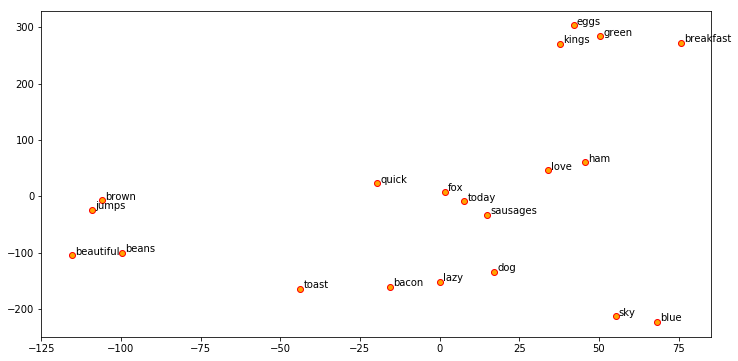

In [38]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

Remember that our corpus is extremely small, so to get meaningful word embeddings and for the model to get more context and semantics:
    <br>
    1. we need more data

Now what is a word embedding in this scenario?:
    <br>
    1. it's typically a dense vector for each word

In [39]:
w2v_model.wv['sky']

array([-0.00550217,  0.00225758,  0.05222183,  0.08953774, -0.09186712,
       -0.07102545,  0.06703829,  0.09108812, -0.05248048, -0.03727874],
      dtype=float32)

In [40]:
# Strategy for Getting Document Embeddings

Now suppose we wanted to cluster the eight documents from our toy corpus:
    <br>
    1. we would need to get the document-level embeddings from each of the words present in each document
    2. One strategy:
        1. would be to average the word embeddings for each word in a document
        2. this is an extremely useful strategy and you can adopt it to your own problems

let's apply this on  our corpus to get features for each document

In [41]:
#num_features, feature_size = 10
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype='float64')
    nwords=0
    
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)#average value of vector representation
    return feature_vector    

In [47]:
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model.wv, vocabulary, num_features)#model.wv instead of model
                    for tokenized_sentence in corpus]
    return np.array(features)

In [48]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9
0,-0.002563,-0.007418,0.034811,0.026904,-0.053587,-0.035993,0.061499,0.014958,-0.047006,-0.059281
1,0.003990,-0.017028,0.047207,-0.004556,-0.022574,-0.019438,0.034795,0.022913,-0.040348,-0.027406
2,-0.025970,0.044765,-0.027590,-0.042492,0.038190,0.001035,0.020798,0.014793,-0.009800,0.026013
3,-0.004875,-0.023161,0.012324,0.017017,0.023751,0.013767,0.019178,-0.004341,0.008625,0.013524
4,0.002887,-0.026936,0.028622,0.022390,0.038067,0.033622,0.020794,0.024426,-0.022648,0.036913
5,0.000605,0.036747,-0.027230,-0.022999,0.024138,-0.010912,0.013114,0.026146,-0.036314,-0.000790
6,-0.000502,-0.007114,0.035939,0.018142,-0.055835,-0.030537,0.061412,0.022556,-0.058082,-0.034085
7,-0.013937,0.047206,-0.023748,-0.040617,0.038326,-0.009574,0.009073,0.029035,-0.026323,0.017736


In [53]:
vocabulary = set(w2v_model.wv.index_to_key)

Now that we have our features for each document, let's cluster these documents using the affinity propagation algorithm:
    <br>
    1. which is a clustering algorithm based on the concept of 'message passing' between data points
    2. it does not need the number of clusters as an explicit input, which is often required by partition-based clustering algorithm

In [55]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beautiful today,weather,1
7,The dog is lazy but the brown fox is quick!,animals,2


clusters assigned based on the document features from Word2Vec

We can see that our algorithm has clustered each document into the right group
based on our Word2Vec features

We can also visualize how each document
is positioned in each cluster by using Principal Component Analysis (PCA) to reduce the
feature dimensions to 2D and then visualizing them (by color coding each cluster)

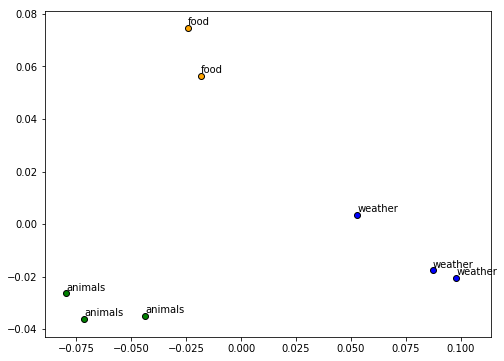

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

Everything looks to be in order, as documents in each cluster are closer to each other
and far apart from the other clusters.